In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_ratio = 0.8
validation_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

In [5]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [7]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_cnn1 = CNN1().to(device)
optimizer = optim.Adam(net_cnn1.parameters(), lr=learning_rate)

In [8]:
seed = 42
torch.manual_seed(seed)

Epoch [1/20], Train Loss: 0.7874, Train Accuracy: 81.79%, Validation Loss: 0.4909, Validation Accuracy: 81.75%
Epoch [2/20], Train Loss: 0.4995, Train Accuracy: 85.56%, Validation Loss: 0.3918, Validation Accuracy: 85.38%
Epoch [3/20], Train Loss: 0.4254, Train Accuracy: 86.06%, Validation Loss: 0.3835, Validation Accuracy: 85.86%
Epoch [4/20], Train Loss: 0.3820, Train Accuracy: 88.19%, Validation Loss: 0.3339, Validation Accuracy: 87.62%
Epoch [5/20], Train Loss: 0.3587, Train Accuracy: 89.34%, Validation Loss: 0.3109, Validation Accuracy: 88.43%
Epoch [6/20], Train Loss: 0.3332, Train Accuracy: 89.35%, Validation Loss: 0.3164, Validation Accuracy: 88.31%
Epoch [7/20], Train Loss: 0.3167, Train Accuracy: 89.75%, Validation Loss: 0.3058, Validation Accuracy: 88.81%
Epoch [8/20], Train Loss: 0.3019, Train Accuracy: 90.11%, Validation Loss: 0.3000, Validation Accuracy: 89.03%
Epoch [9/20], Train Loss: 0.2887, Train Accuracy: 90.12%, Validation Loss: 0.3101, Validation Accuracy: 89.08%
E

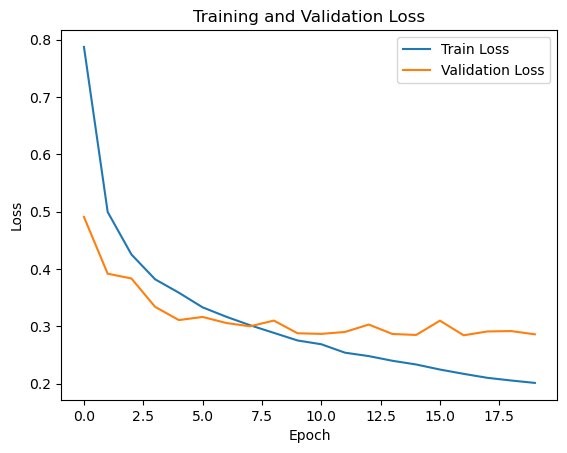

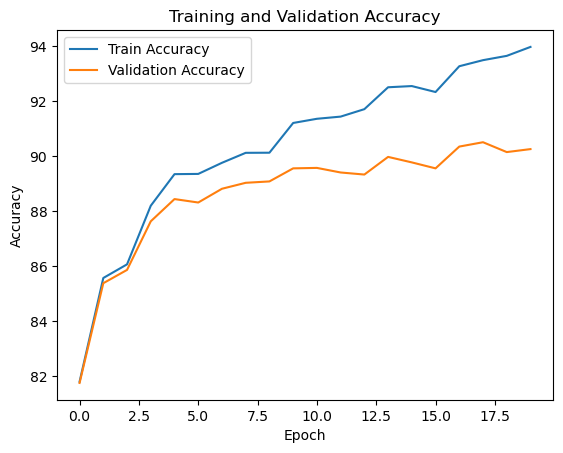

Test Accuracy: 89.48%


In [9]:
def def_accuracy(loader):
    net_cnn1.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_cnn1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Addestramento del modello
num_epochs = 20
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
best_validation_accuracy = 0.0
patience = 5
counter = 0

for epoch in range(num_epochs):
    net_cnn1.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_cnn1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = def_accuracy(train_loader)
    validation_loss = 0.0
    validation_accuracy = def_accuracy(validation_loader)
    
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_cnn1(inputs)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
        
    validation_loss /= len(validation_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    # Check for early stopping
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Plot Losses and Accuracies
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Calcolare e stampare l'accuracy sul test set
test_accuracy = def_accuracy(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Second CNN with dropout 0.3

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
net_cnn2 = CNN2().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_cnn2.parameters(), lr=0.001, momentum=0.9)

In [12]:
def def_accuracy(loader):
    net_cnn2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_cnn2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model
num_epochs = 20
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
best_validation_accuracy = 0.0
patience = 5
counter = 0

Epoch [1/20], Train Loss: 1.8555, Train Accuracy: 64.82%, Validation Loss: 0.8968, Validation Accuracy: 65.79%
Epoch [2/20], Train Loss: 0.8901, Train Accuracy: 73.05%, Validation Loss: 0.6868, Validation Accuracy: 73.92%
Epoch [3/20], Train Loss: 0.7495, Train Accuracy: 75.85%, Validation Loss: 0.6030, Validation Accuracy: 76.53%
Epoch [4/20], Train Loss: 0.6773, Train Accuracy: 77.24%, Validation Loss: 0.5630, Validation Accuracy: 77.56%
Epoch [5/20], Train Loss: 0.6351, Train Accuracy: 79.30%, Validation Loss: 0.5274, Validation Accuracy: 79.45%
Epoch [6/20], Train Loss: 0.6004, Train Accuracy: 80.10%, Validation Loss: 0.5120, Validation Accuracy: 80.01%
Epoch [7/20], Train Loss: 0.5763, Train Accuracy: 81.12%, Validation Loss: 0.4841, Validation Accuracy: 81.33%
Epoch [8/20], Train Loss: 0.5562, Train Accuracy: 82.12%, Validation Loss: 0.4691, Validation Accuracy: 82.20%
Epoch [9/20], Train Loss: 0.5383, Train Accuracy: 82.94%, Validation Loss: 0.4538, Validation Accuracy: 83.13%
E

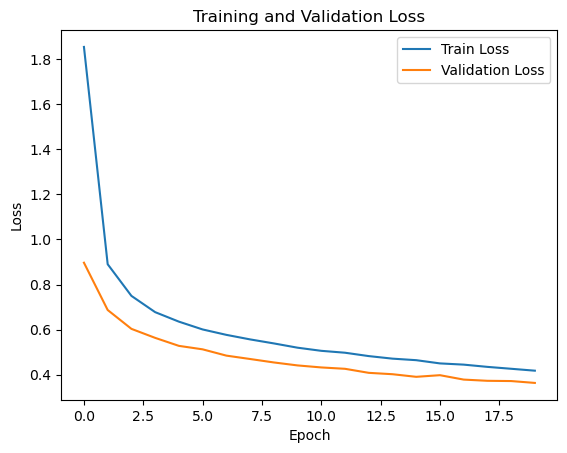

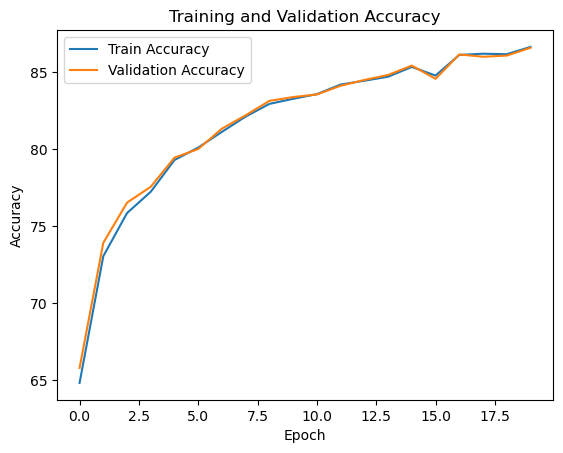

Test Accuracy: 85.30%


In [13]:
for epoch in range(num_epochs):
    net_cnn2.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_cnn2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = def_accuracy(train_loader)
    validation_loss = 0.0
    validation_accuracy = def_accuracy(validation_loader)
    
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_cnn2(inputs)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
        
    validation_loss /= len(validation_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    # Check for early stopping
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Plot Losses and Accuracies
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Calcolare e stampare l'accuracy sul test set
test_accuracy = def_accuracy(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Third CNN

In [25]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # L'output del secondo max pooling sarà di dimensioni 7x7
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)  # Appiattimento prima dei layer fully connected
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definizione della rete CNN3
net_cnn3 = CNN3().to(device)

# Definizione della loss e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_cnn3.parameters(), lr=0.001)


Epoch [1/20], Train Loss: 0.0329, Train Accuracy: 99.28%, Validation Loss: 0.3408, Validation Accuracy: 92.92%
Epoch [2/20], Train Loss: 0.0247, Train Accuracy: 99.49%, Validation Loss: 0.3808, Validation Accuracy: 93.33%
Epoch [3/20], Train Loss: 0.0216, Train Accuracy: 99.53%, Validation Loss: 0.4082, Validation Accuracy: 92.78%
Epoch [4/20], Train Loss: 0.0209, Train Accuracy: 99.48%, Validation Loss: 0.4648, Validation Accuracy: 92.92%
Epoch [5/20], Train Loss: 0.0252, Train Accuracy: 99.03%, Validation Loss: 0.3940, Validation Accuracy: 92.37%
Epoch [6/20], Train Loss: 0.0222, Train Accuracy: 99.56%, Validation Loss: 0.3605, Validation Accuracy: 92.92%
Epoch [7/20], Train Loss: 0.0195, Train Accuracy: 99.36%, Validation Loss: 0.4131, Validation Accuracy: 92.56%
Early stopping for CNN3...


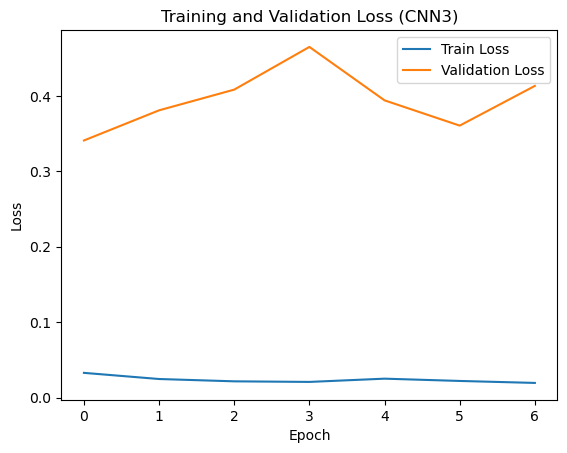

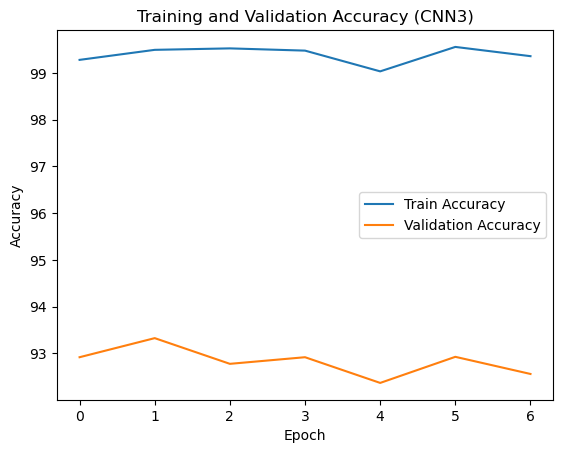

Test Accuracy (CNN3): 92.54%


In [32]:
# Train the model
num_epochs = 20
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
best_validation_accuracy = 0.0
patience = 5
counter = 0
best_val_loss = float('inf')

def def_accuracy(loader):
    net_cnn3.eval()  # Assicurati che la rete CNN3 sia impostata su modalità di valutazione
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_cnn3(images)  # Utilizza la rete CNN3 per calcolare le previsioni
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

for epoch in range(num_epochs):
    net_cnn3.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_cnn3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = def_accuracy(train_loader)
    validation_loss = 0.0
    validation_accuracy = def_accuracy(validation_loader)
    
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_cnn3(inputs)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
        
    validation_loss /= len(validation_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    # Check for early stopping
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        counter_cnn3 = 0
    else:
        counter_cnn3 += 1
        if counter_cnn3 >= patience:
            print("Early stopping for CNN3...")
            break

# Plot Losses and Accuracies for CNN3
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN3)')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (CNN3)')
plt.legend()
plt.show()

# Calcolare e stampare l'accuracy sul test set per CNN3
test_accuracy_cnn3 = def_accuracy(test_loader)
print(f'Test Accuracy (CNN3): {test_accuracy_cnn3:.2f}%')